In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [191]:
def calc_rhs(A_fin, A_base, N, k, t, H, h):
    eta = calc_eta(calc_m(k, t, h), H)
    return 1 / (h*(A_base + N * eta * A_fin))
    
def calc_m(k, t, h):
    return np.sqrt(2*h / (k*t))

def calc_eta(m, H):
    return np.tanh(m*H)/(m*H)

def determine_N(spacing, t):
    return int(W/(spacing+t))

# material properties
k_al = 210
k_cu = 400

# air velocity properties
v = np.arange(0, 20, 0.1)
h = 10.45 - v + 10*np.sqrt(v)

# figure properties
single_fig = (10, 6)
double_fig = (16, 6)

# air properties at STP
roe = 1.1614 # kg/m^3
c_p = 1.007 # kJ/(kg K)
meu = 184e-7 # (N s)/m^2
neu = 15.89e-6 # m^2/s
k_air = 26.3e-3 #W/(m K)
alpha_air = 22.5e-6 # m^2 /s
Pr = 0.707

In [60]:
# Edit here
t = 0.0002 # fin thickness
N = 8 # number of fins
H = 0.05 # fin height
L = 0.045 # heat sink length
W = 0.025 # heat sink width
k = k_al # for aluminum
# k = k_cu # for copper

## Evaluating the Limits of Air Cooled Thermal Systems
Ognyan Moore

We can build a $16\frac{W}{cm^2}$ air cooled product; find out how I know

## Overview

Thermal Systems can be modeled like electrical circuits, where each component that the heat has to travel through is modeled like a resistor as such:

$$ Q = \frac{T_{JC} - T_{AMB}}{R_{TH}} $$

$Q$ is the thermal power we need to dissipate

$T_{JC}$ is the juction temperature of our devices

$R_{TH}$ is the thermal resistance of our cooling system

### In order to accomodate large values of $Q$, we need low values for $R_{TH}$ such that our $T_{JC}$ does not exceed rated values.

## More precisely, the thermal circuit looks like this:

![Equivalent Circuit](images/Equivalient_thermal_circuit_2.png)

### Lowering R values results in lower T values for a Given Q

$Q$ is the thermal power

$T_J$ is the junction temperature of the device

$T_C$ is the temperature at the case of the device

$T_H$ is the temperature where the heat-sink as attached

$T_{AMB}$ is the ambient temperature 

From the data done at Mentor Graphs on the FJ100, we actually have a really good idea of what $R_{\theta JC} + R_{\theta CH}$  should be.  Since we use similar (or in some cases identical SLMs and LEDs) from product to product, these values are good to use for other types of analysis.

<h3 align='center'> T3ster Data for the FJ100</h3>
![T3ster Data](images/T3ster_data.png)

$$R_{\theta JC} + R_{\theta CH} = 0.18\frac{K}{W}$$

![Equivalent Circuit](images/Equivalient_thermal_circuit_2.png)
We now know what $T_J$ cannot exceed ($125^\circ C$), we know what $R_{\theta JC} + R_{\theta CH}$ is, and we know what $T_{AMB}$ is.

Using optical modeling from Doug, in addition to quantum efficiency measurements we take in-house, we can estimate what $Q$ (heat generated) will be in relation to a target $\frac{W}{cm^2}$ irradiance.

So how do we calculate the thermal resistance of a heat sink $(R_{\theta HA}$ ) to see if we have a product that will be feasible?

It's complicated, but not that complicated...

Heat that is dissipated through heat sinks needs to propogate through the base, and then conduct partially through the fins before being convected away to the ambient air.  Here is where the math starts getting messy....

<h3 align='center'>
Thermal Resistance of a Heatsink
</h3>

**$$R_{\theta HA} = R_{HS} + \frac{B}{kWL}$$**

$B$ is the thickness of the base

$k$ is the thermal conductivity of the material

$W$ is the width of the heat sink

$L$ is the length of the heat sink

**$$R_{HS} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})}$$**

$h$ is the convection coefficient (we will actually be solving for this value in the end)

$A_{base}$ is the area of the base that is exposed to air-flow

$N_{fin}$ is the number of fins

$\eta_{fin}$ is the fin efficiency (more on this later)

$A_{fin}$ is the surface area of each fin

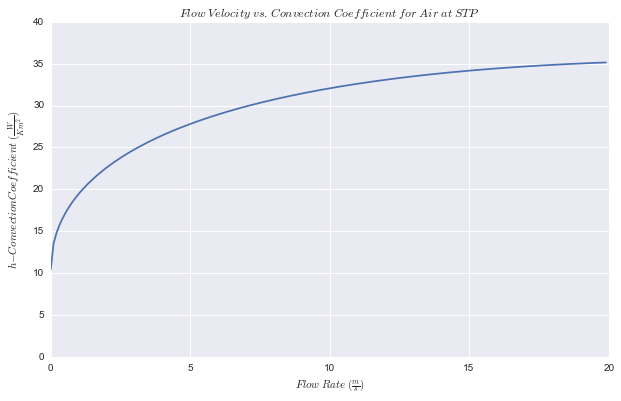

In [181]:
fig, ax = plt.subplots(figsize=single_fig)
ax.plot(v, h)
ax.set_title('$Flow \ Velocity \ vs. \ Convection \ Coefficient \ for \ Air \ at \ STP$')
ax.set_xlabel(r'$Flow \ Rate \ (\frac{m}{s})$')
ax.set_ylabel(r'$h - Convection Coefficient \ (\frac{W}{K m^2})$')
ax.set_ylim(bottom=0)
plt.show()

$$R_{HS} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})}$$

$h$ is the convection coefficient (**typically between $10-35 \frac{W}{m^2K}$**)

$A_{base}$ is the area of the base that is exposed to air-flow

$N_{fin}$ is the number of fins

$\eta_{fin}$ is the fin efficiency (more on this later)

$A_{fin}$ is the surface area of each fin

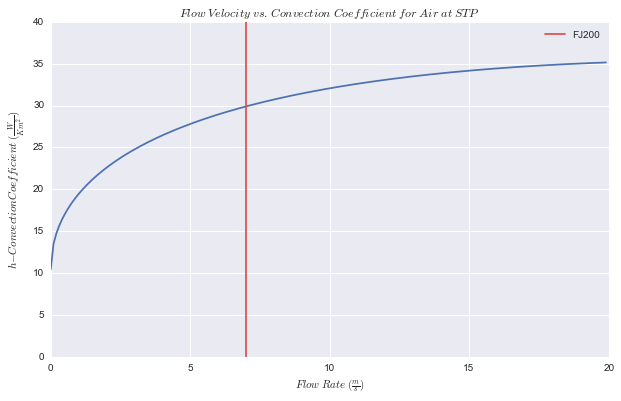

In [183]:
fig, ax = plt.subplots(figsize=single_fig)
ax.plot(v, h)
ax.set_title('$Flow \ Velocity \ vs. \ Convection \ Coefficient \ for \ Air \ at \ STP$')
ax.set_xlabel(r'$Flow \ Rate \ (\frac{m}{s})$')
ax.set_ylabel(r'$h - Convection Coefficient \ (\frac{W}{K m^2})$')
ax.set_ylim(bottom=0)
ax.axvline(x=7, color=sns.xkcd_rgb["pale red"], label='FJ200')
plt.legend(loc='best')
plt.show()

<h3 align='center'>
Fin Efficiency
</h3>


$$\eta_{fin} = \frac{tanh(m H_{fin})}{m H_{fin}}$$


$H_{fin}$ is the height of the fin

$$ m = \sqrt{ \frac{2h}{k_{fin}t_{fin}}}$$

$k_{fin}$ is the thermal conductivity of the fin material

$t_{fin}$ is the thickness of the fin

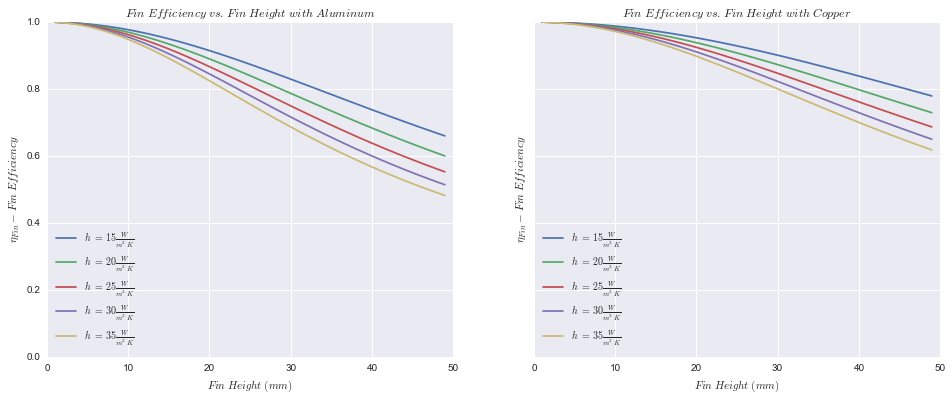

In [290]:
H = np.arange(0, 0.05, 0.001)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=double_fig, sharey=True, dpi=400)
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax1.plot(H*1000, calc_eta(calc_m(k_al, t, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax1.set_xlabel(r'$Fin \ Height \ (mm)$')
ax1.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax1.set_ylim(bottom=0)
ax1.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Height \ with \ Aluminum$')
ax1.legend(loc='best')


ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax2.plot(H*1000, calc_eta(calc_m(k_cu, t, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax2.set_xlabel(r'$Fin \ Height \ (mm)$')
ax2.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax2.set_ylim(bottom=0)
ax2.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Height \ with \ Copper$')
ax2.legend(loc='best')

plt.show()

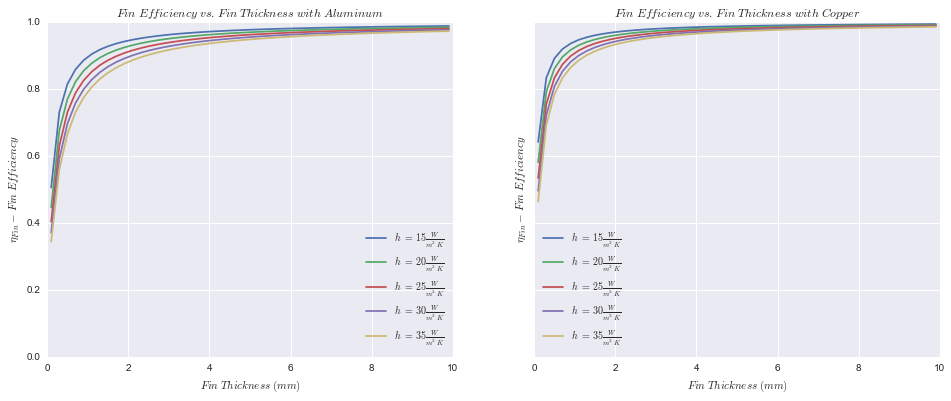

In [284]:
thickness = np.arange(0.0001, 0.010, 0.0002)
H = 0.05

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=double_fig, sharey=True, dpi=400)
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax1.plot(thickness*1000, calc_eta(calc_m(k_al, thickness, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax1.set_xlabel(r'$Fin \ Thickness \ (mm)$')
ax1.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax1.set_ylim(bottom=0)
ax1.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Thickness \ with \ Aluminum$')
ax1.legend(loc='best')
ax1.plot()

ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 15), H), label=r'$h \ = \ 15 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 20), H), label=r'$h \ = \ 20 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 25), H), label=r'$h \ = \ 25 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 30), H), label=r'$h \ = \ 30 \frac{W}{m^2K}$')
ax2.plot(thickness*1000, calc_eta(calc_m(k_cu, thickness, 35), H), label=r'$h \ = \ 35 \frac{W}{m^2K}$')
ax2.set_xlabel(r'$Fin \ Thickness \ (mm)$')
ax2.set_ylabel(r'$\eta_{Fin} \ - \ Fin \ Efficiency$')
ax2.set_ylim(bottom=0)
ax2.set_title(r'$Fin \ Efficiency \ vs. \ Fin \ Thickness \ with \ Copper$')
ax2.legend(loc='best')
ax2.plot()
plt.show()

But **efficiency** isn't what we are after...

We want to **minimize** $R_{TH}$

$$ Q = \frac{T_{JC} - T_{AMB}}{R_{TH}} $$

$$R_{TH} = \frac{1}{h (A_{base} + N_{fin} \ \eta_{fin} \ A_{fin})} + \frac{B}{kWL} + 0.18 \frac{K}{W}$$


From looking at the formula, it appears the best way to do that is to increase $N_{fin}$ and $A_{fin}$ to values as high as possible

However, we can only space the fins so close together...

Why can't we place a near infinate number of fins right up against one-another?  Boundary layers!

$$\delta \approx \frac{5L}{\sqrt{Re}}$$

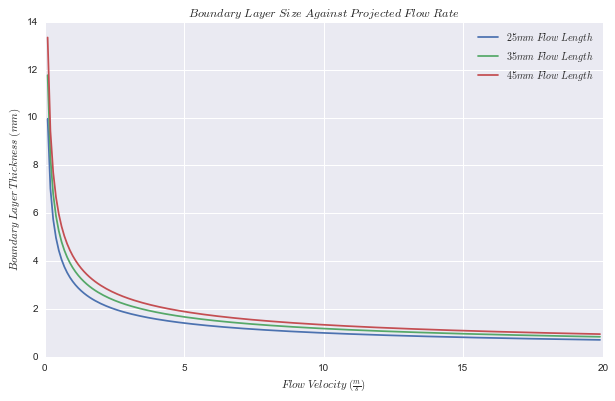

In [291]:
#############
# Discussion of Boundary Layers Here
#############

delta = 5 * W / np.sqrt((roe*v*W) / meu)
fig, ax1 = plt.subplots(figsize=single_fig)
ax1.plot(v, (5 * 0.025 / np.sqrt((roe*v*.025) / meu))*1000, label=r"$25mm \ Flow \ Length$")
ax1.plot(v, (5 * 0.035 / np.sqrt((roe*v*.035) / meu))*1000, label=r"$35mm \ Flow \ Length$")
ax1.plot(v, (5 * 0.045 / np.sqrt((roe*v*.045) / meu))*1000, label=r"$45mm \ Flow \ Length$")
ax1.set_title(r'$Boundary \ Layer \ Size \ Against \ Projected \ Flow \ Rate$')
ax1.set_xlabel(r'$Flow \ Velocity \ (\frac{m}{s})$')
ax1.set_ylabel(r'$Boundary \ Layer \ Thickness \ (mm)$')
ax1.legend(loc='best')
plt.show()

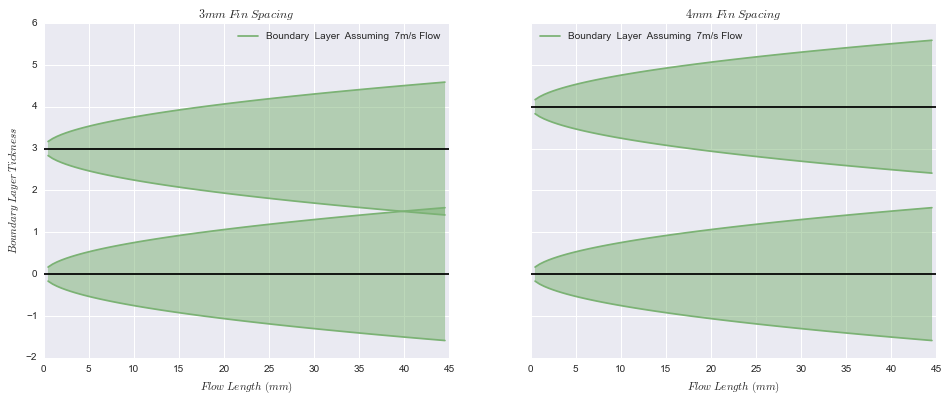

In [269]:
x = np.arange(0, .045, 0.0005)
V = 7
delta = 5 * x / np.sqrt((roe*V*x)/meu) * 1000
color=sns.xkcd_rgb["faded green"]
alpha=0.5

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=double_fig, sharey=True)
fin_spacing = 3
ax1.fill_between(x*1000, 0, delta, color=color, alpha=alpha)
ax1.plot(x*1000, delta, color=color, label='Boundary  Layer  Assuming  {}m/s Flow'.format(V))
ax1.set_ylabel(r'$Boundary \ Layer \ Tickness$')
ax1.fill_between(x*1000, 0, -delta, color=color, alpha=alpha)
ax1.plot(x*1000, -delta, color=color)
ax1.axhline(y=0, color='k')

ax1.fill_between(x*1000, fin_spacing, delta+fin_spacing, color=color, alpha=alpha)
ax1.plot(x*1000, -delta+fin_spacing, color=color)
ax1.fill_between(x*1000, fin_spacing, -delta+fin_spacing, color=color, alpha=alpha)
ax1.plot(x*1000, delta+fin_spacing, color=color)
ax1.axhline(y=fin_spacing, color='k')
ax1.set_title(r'$3mm \ Fin \ Spacing$')
ax1.set_xlabel(r'$Flow \ Length \ (mm)$')
ax1.legend(loc='best')

fin_spacing = 4
ax2.plot(x*1000, -delta, color=color)
ax2.plot(x*1000, delta, color=color)
ax2.fill_between(x*1000, 0, delta, color=color, alpha=0.5)
# ax2.set_ylabel(r'$Boundary \ Layer \ Tickness$')
ax2.fill_between(x*1000, 0, -delta, color=color, alpha=0.5)
ax2.axhline(y=0, color='k')

ax2.plot(x*1000, -delta+fin_spacing, color=color, label='Boundary  Layer  Assuming  {}m/s Flow'.format(V))
ax2.plot(x*1000, delta+fin_spacing, color=color)
ax2.fill_between(x*1000, fin_spacing, delta+fin_spacing, color=color, alpha=alpha)
ax2.fill_between(x*1000, fin_spacing, -delta+fin_spacing, color=color, alpha=alpha)
ax2.axhline(y=fin_spacing, color='k')
ax2.set_title(r'$4mm \ Fin \ Spacing$')
ax2.set_xlabel(r'$Flow \ Length \ (mm)$')
ax2.legend(loc='best')
plt.show()

First Question...

What does Copper buy us here?

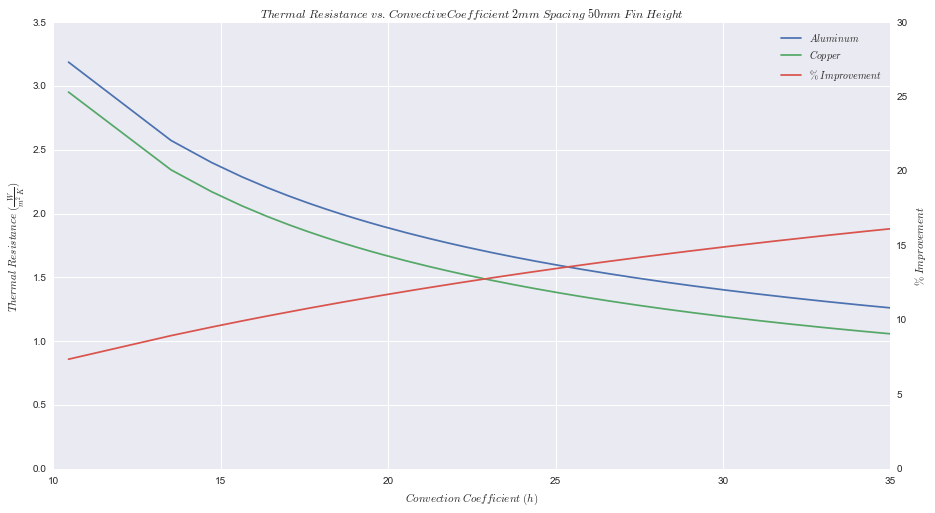

In [174]:
spacing = .002
H = 0.035
N = int(.025/(spacing+t))
A_base = W*L-(L*t*N)
A_fin = 2 * L * H 

delta = (calc_rhs(A_fin, A_base, determine_N(spacing, t), k_al, t, H, h) - calc_rhs(A_fin, A_base, determine_N(spacing, t), k_cu, t, H, h))/calc_rhs(A_fin, A_base, determine_N(spacing, t), k_al, t, H, h)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,8))
ax.set_title(r'$Thermal \ Resistance \ vs. \ Convective Coefficient \ 2mm \ Spacing \ 50mm \ Fin \ Height$')
ax.plot(h, calc_rhs(A_fin, A_base, determine_N(spacing, t), k_al, t, H, h), label=r'$Aluminum$')
ax.plot(h, calc_rhs(A_fin, A_base, determine_N(spacing, t), k_cu, t, H, h), label=r'$Copper$')
# ax.legend(loc='best')
ax.set_xlim(right=35)
ax.set_ylabel(r'$Thermal \ Resistance \ (\frac{W}{m^2K})$')
ax.set_xlabel(r'$Convection \ Coefficient \ (h)$')
ax.set_ylim(bottom=0)
h1, l1 = ax.get_legend_handles_labels()

ax_s = ax.twinx()
ax_s.plot(h, delta*100, color=sns.xkcd_rgb["pale red"], label=r'$\% \ Improvement$')
ax_s.set_ylabel(r'$\% \ Improvement$')
ax_s.set_ylim([0, 30])
ax_s.grid(False)
ax_s.set_xlim(right=35)
h2, l2 = ax_s.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='best')
plt.show()


References: 

http://www.electronics-cooling.com/2003/02/estimating-parallel-plate-fin-heat-sink-thermal-resistance/

https://en.wikipedia.org/wiki/Thermal_resistance

http://www.engineeringtoolbox.com/convective-heat-transfer-d_430.html